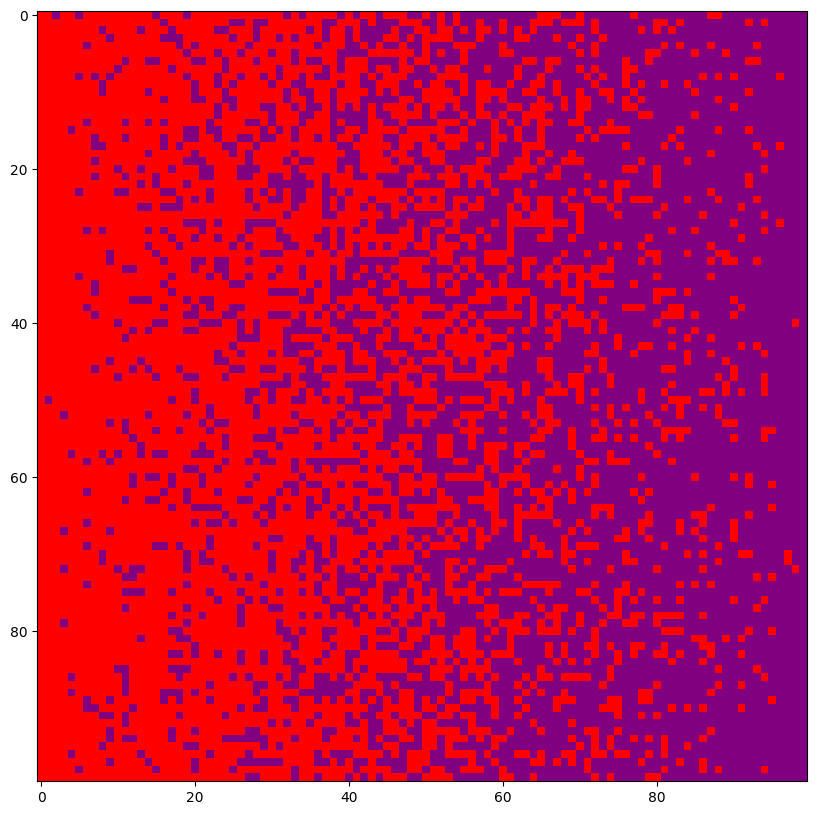

In [9]:
from main import LearningModel

#Here you can run a model once with different learning models and food environments. 
#You can either use 'TD', 'RW', or 'RWE' at learning_model.
#You can pick 'random', 'gradient_l', 'gradient_h', 'weekday' as food environments.
#You can also fill in an integer (e.g., 1) after seed to make the simulation reproducible.

m = LearningModel(N=100, width=100, height=100, learning_model='RWE', distribute_patches = 'gradient_h', seed = None)

for i in range(100):
    m.step()

df = m.datacollector.get_agent_vars_dataframe()
df1 = df.reset_index()

m.visualize() #In case you want to check distribution of food on map.

Text(0, 0.5, 'V')

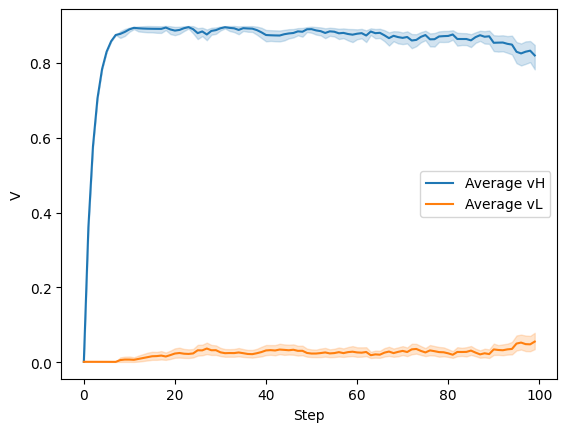

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot the results of the single run.

sns.lineplot(df1, x = "Step", y = "Value_High", label = "Average vH")
sns.lineplot(df1, x = "Step", y = "Value_Low", label = "Average vL")
plt.ylabel('V')

In [19]:
from main import LearningModel
from tqdm import tqdm 
import pandas as pd

#With the batch_run function you can run the model in 6 different configurations as often as you like. This will return a dataframe called "data".
#The dataframe contains time-series data for all agents for every single run in the 6 different configurations.

iterations = 10
learning_models = ["RW", "TD", "RWE"]
distribute_patches = ["random", "gradient_h", "gradient_l", "weekday"]

def batch_run():
    all_data = []
    
    total_runs = len(learning_models) * len(distribute_patches) * iterations
    progress_bar = tqdm(total=total_runs, desc="Batch Running")

    for learning_model in learning_models:
        for distribute_patch in distribute_patches:
            batch_run_data = []
            for i in range(iterations):
                model = LearningModel(N=100, width=100, height=100, learning_model=learning_model, distribute_patches=distribute_patch)
                
                # Run the model for a fixed number of steps
                for _ in range(100):
                    model.step()
                
                # Get model data
                m_data = model.datacollector.get_agent_vars_dataframe()
                m_data['Run'] = i
                m_data['Learning_Model'] = learning_model
                m_data['Distribute_Patches'] = distribute_patch
                batch_run_data.append(m_data)

                progress_bar.update(1)
            
            # Concatenate the data for this configuration
            batch_run_data = pd.concat(batch_run_data)
            all_data.append(batch_run_data)
    
    # Concatenate all configurations
    all_data = pd.concat(all_data)
    
    return all_data

# Run the custom batch run function
data = batch_run()

Batch Running: 100%|██████████| 120/120 [00:16<00:00,  7.44it/s]


In [20]:
data = data.reset_index()

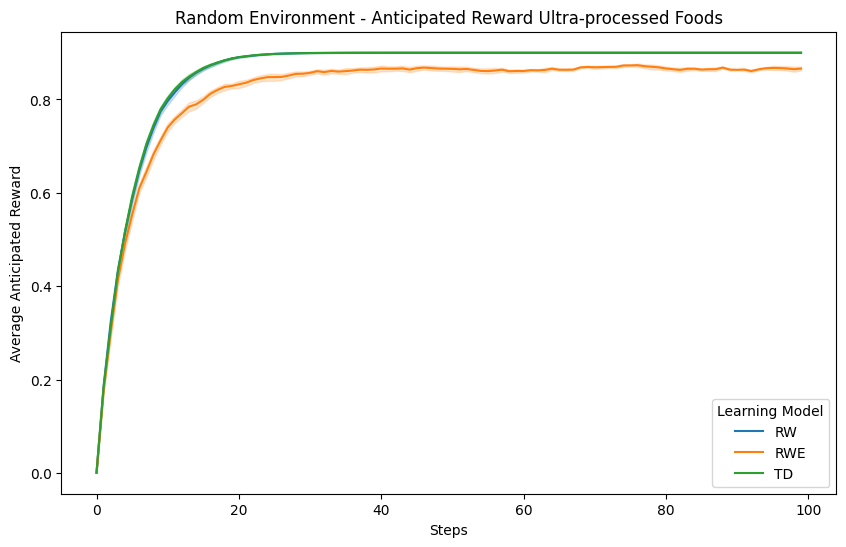

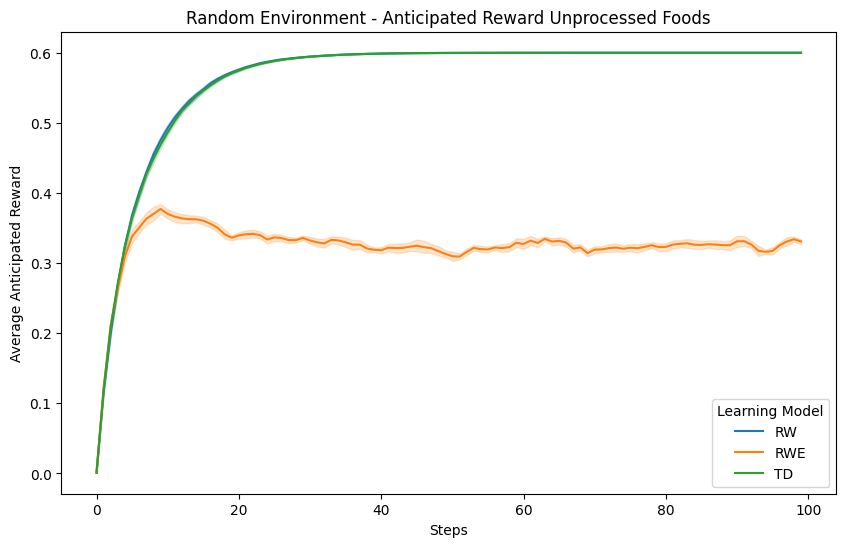

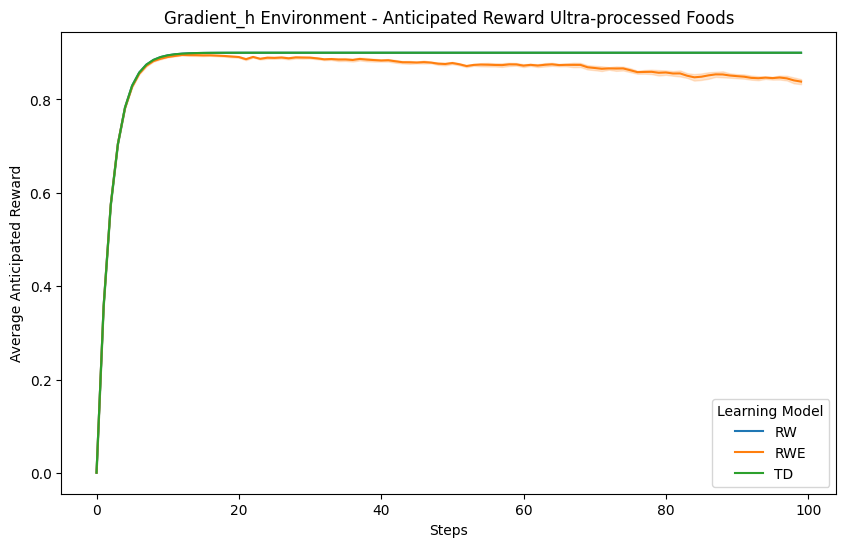

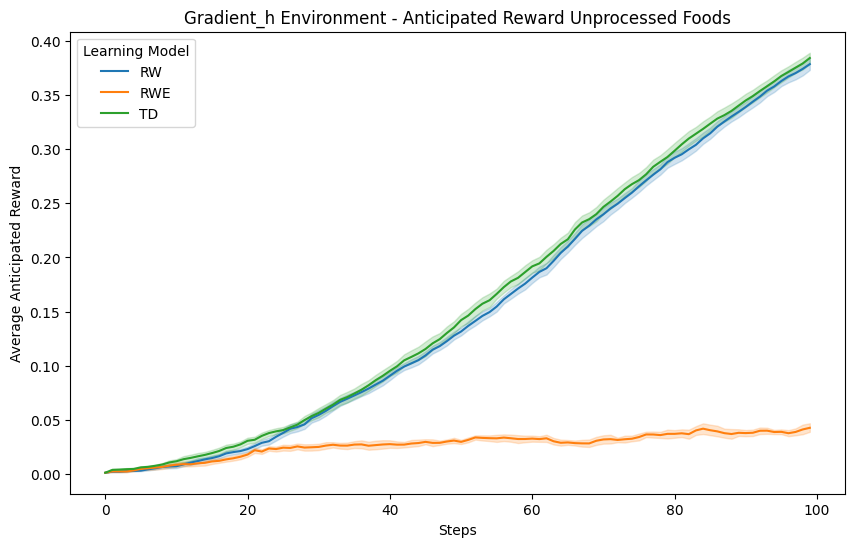

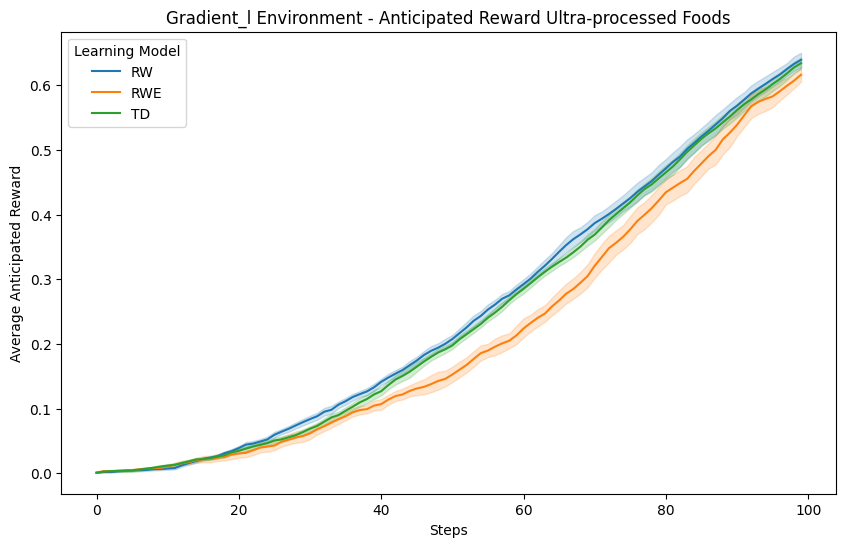

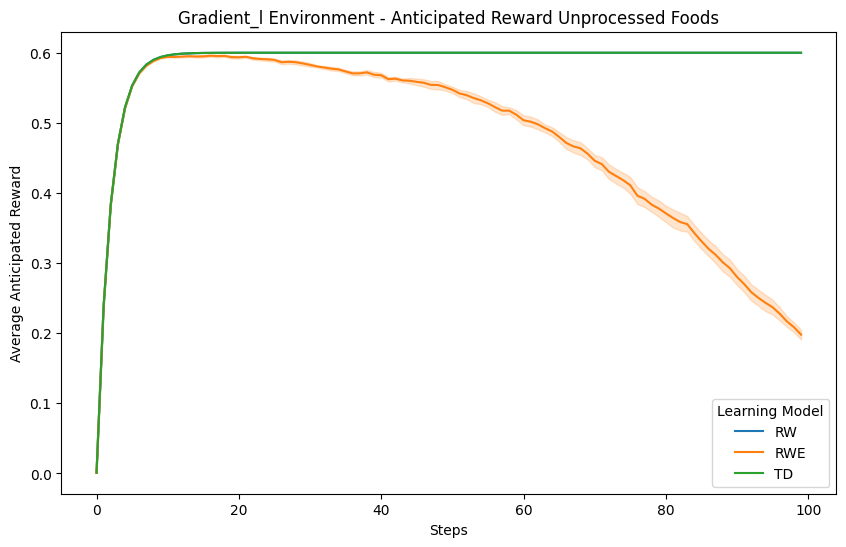

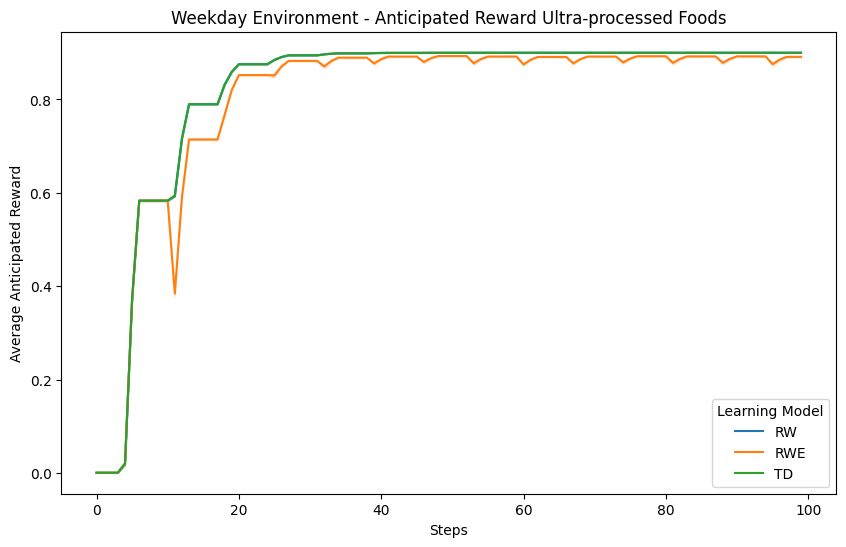

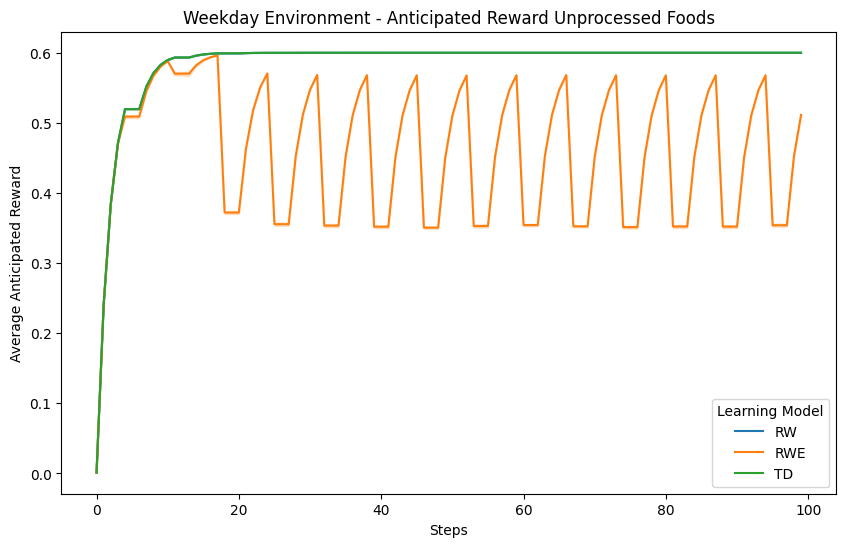

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(data, distribute_patch):
    # Filter data for the specific distribute_patch
    df_filtered = data[data['Distribute_Patches'] == distribute_patch]
    
    # Group by step, learning model, and run to get the mean value_high and value_low
    df_grouped = df_filtered.groupby(['Step', 'Learning_Model', 'Run'])[['Value_High', 'Value_Low']].mean().reset_index()

    # Plot the data using seaborn
    plt.figure(figsize=(10, 6))
    
    # Plot Value_High
    sns.lineplot(data=df_grouped, x='Step', y='Value_High', hue='Learning_Model', estimator='mean', errorbar=('ci', 80))
    plt.title(f'{distribute_patch.capitalize()} Environment - Anticipated Reward Ultra-processed Foods')
    plt.xlabel('Steps')
    plt.ylabel('Average Anticipated Reward')
    plt.legend(title='Learning Model')
    plt.show()
    
    # Plot Value_Low
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_grouped, x='Step', y='Value_Low', hue='Learning_Model', estimator='mean', errorbar=('ci', 80))
    plt.title(f'{distribute_patch.capitalize()} Environment - Anticipated Reward Unprocessed Foods')
    plt.xlabel('Steps')
    plt.ylabel('Average Anticipated Reward')
    plt.legend(title='Learning Model')
    plt.show()

# Plot results for each distribute_patch
for distribute_patch in distribute_patches:
    plot_results(data, distribute_patch)